In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import ks_2samp

import helper_functions.config as config

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [2]:
def recursive_sample(df, target_n, samples, p_val_cutoff, stratified_features):
    
    # base condition
    if len(df) < target_n:
        samples.append(df)
    
    # recursion condition
    else:
        sample_size = int(len(df) // 2)
        
        while True:
            left_sample, right_sample = random_split(df, sample_size)
            ks_pvals = ks_test(left_sample, right_sample, stratified_features)
            
            if all(p_vals >= p_val_cutoff for p_vals in ks_pvals):
                print("Good split on sample size {}".format(sample_size))
                break
            
            #print("Rejected split on sample size {}".format(sample_size))
            
        recursive_sample(left_sample, target_n, samples, p_val_cutoff, stratified_features)
        recursive_sample(right_sample, target_n, samples, p_val_cutoff, stratified_features)
    
    return samples

def random_split(df, sample_size):
    df_size = len(df)
    indices = random.sample(range(0, df_size), df_size)
    left_indicies = indices[sample_size:]
    right_indicies = indices[:sample_size]
    
    return df.iloc[left_indicies], df.iloc[right_indicies]

def ks_test(left_sample, right_sample, stratified_features):
    
    ks_pvals = []

    for feature in stratified_features:
        left = np.array(left_sample[feature])
        right = np.array(right_sample[feature])

        ks_result = ks_2samp(left, right)
        ks_pvals.append(ks_result[1])
    
    return ks_pvals


In [3]:
output_data_file_basename = "/mnt/SSD/data/stratified_training_data/1992-2015_california_features_added_"

# Pick features to stratify
stratified_features = [        
    'lat',
    'lon',
    'month',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
    'max_apcp',
    'max_rhum_2m',
    'max_dpt_2m',
    'max_pres_sfc',
    'max_uwnd_10m',
    'max_vwnd_10m',
    'max_vis',
    'max_cloud_cover',
    'min_air_2m',
    'min_apcp',
    'min_rhum_2m',
    'min_dpt_2m',
    'min_pres_sfc',
    'min_uwnd_10m',
    'min_vwnd_10m',
    'min_vis',
    'min_cloud_cover',     
    'ignition',
    'total_fires',
    'crain',
    'veg'
]

# Pick features to include in output samples
output_features = [
    'lat',
    'lon',
    'date',
    'month',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
    'max_apcp',
    'max_rhum_2m',
    'max_dpt_2m',
    'max_pres_sfc',
    'max_uwnd_10m',
    'max_vwnd_10m',
    'max_vis',
    'max_cloud_cover',
    'min_air_2m',
    'min_apcp',
    'min_rhum_2m',
    'min_dpt_2m',
    'min_pres_sfc',
    'min_uwnd_10m',
    'min_vwnd_10m',
    'min_vis',
    'min_cloud_cover',     
    'ignition',
    'total_fires',
    'crain',
    'veg'
]

# Split until sample is less than or equal to target
target_n = 500000

# For a sucessfull split, each variable must have a KS test p-value
# equal to or greater than the cutoff
p_val_cutoff = 0.3

In [5]:
# Read in and prep data
master_df = pd.read_parquet(config.training_data_file)

In [6]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 35 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int32         
 3   crain             int32         
 4   veg               float32       
 5   ignition          int32         
 6   mean_air_2m       float32       
 7   mean_apcp         float32       
 8   mean_rhum_2m      float32       
 9   mean_dpt_2m       float32       
 10  mean_pres_sfc     float32       
 11  mean_uwnd_10m     float32       
 12  mean_vwnd_10m     float32       
 13  mean_vis          float32       
 14  mean_cloud_cover  float32       
 15  max_air_2m        float32       
 16  max_apcp          float32       
 17  max_rhum_2m       float32       
 18  max_dpt_2m        float32       
 19  max_pres_sfc      float32       
 20  max_uwnd_10m      float32       
 21  max_vwnd

In [7]:
#master_df['month'] = master_df['date'].dt.month

In [8]:
master_df = master_df[output_features]

In [9]:
samples = []
samples = recursive_sample(master_df, target_n, samples, p_val_cutoff, stratified_features)

Good split on sample size 1797030
Good split on sample size 898515
Good split on sample size 449257
Good split on sample size 449257
Good split on sample size 898515
Good split on sample size 449257
Good split on sample size 449257


In [10]:
i = 1
for sample in samples:
    output_file_name = output_data_file_basename+"n"+str(target_n)+"_ks_pval"+str(p_val_cutoff)+"."+str(i)+".parquet"
    sample.to_parquet(output_file_name, index=False)
    
    i += 1

In [11]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 5
fig_cols = 3
plot_height = 30
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1)#,(4,2)
]

data_types = [
    'lat',
    'lon',
    'month',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',    
    'ignition',
    'total_fires'
]

plot_titles = [
    'Latitude',
    'Longitude',
    'Month',
    'Air temperature',
    'Acumulated precipitation',
    'Relative humidity',
    'Dew point',
    'Surface pressure',
    'U-component of wind', 
    'V-component of wind',
    'Visibility',
    'Cloud cover',
    'Ignition',
    'Total fires per bin'
]

weather_variable_labels = [
    'Degrees',
    'Degrees',
    'Month',
    'Temp.',
    'Precipitation',
    'Humidity',
    'Dew point',
    'Pressure',
    'Speed',
    'Speed',
    'km',
    'Percent',
    'Catagorical',
    'Count'
]

x_scales = [
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'linear',
    'log'
]

xlabels = weather_variable_labels
ylabels = ['Fraction observations'] * len(xlabels)

In [12]:
def two_sample_density_plot(
    plot_location, 
    parent_data, 
    sample_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
    x_scale
):
    parent_values, parent_base = np.histogram(parent_data[data_type], bins=40)
    sample_values, sample_base = np.histogram(sample_data[data_type], bins=40)
    
    parent_cumulative = np.cumsum(parent_values) / len(parent_data)
    sample_cumulative = np.cumsum(sample_values) / len(sample_data)

    ax[plot_location].plot(parent_base[:-1], (parent_values/len(parent_data)))
    ax[plot_location].plot(sample_base[:-1], (sample_values/len(sample_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_xscale(x_scale)

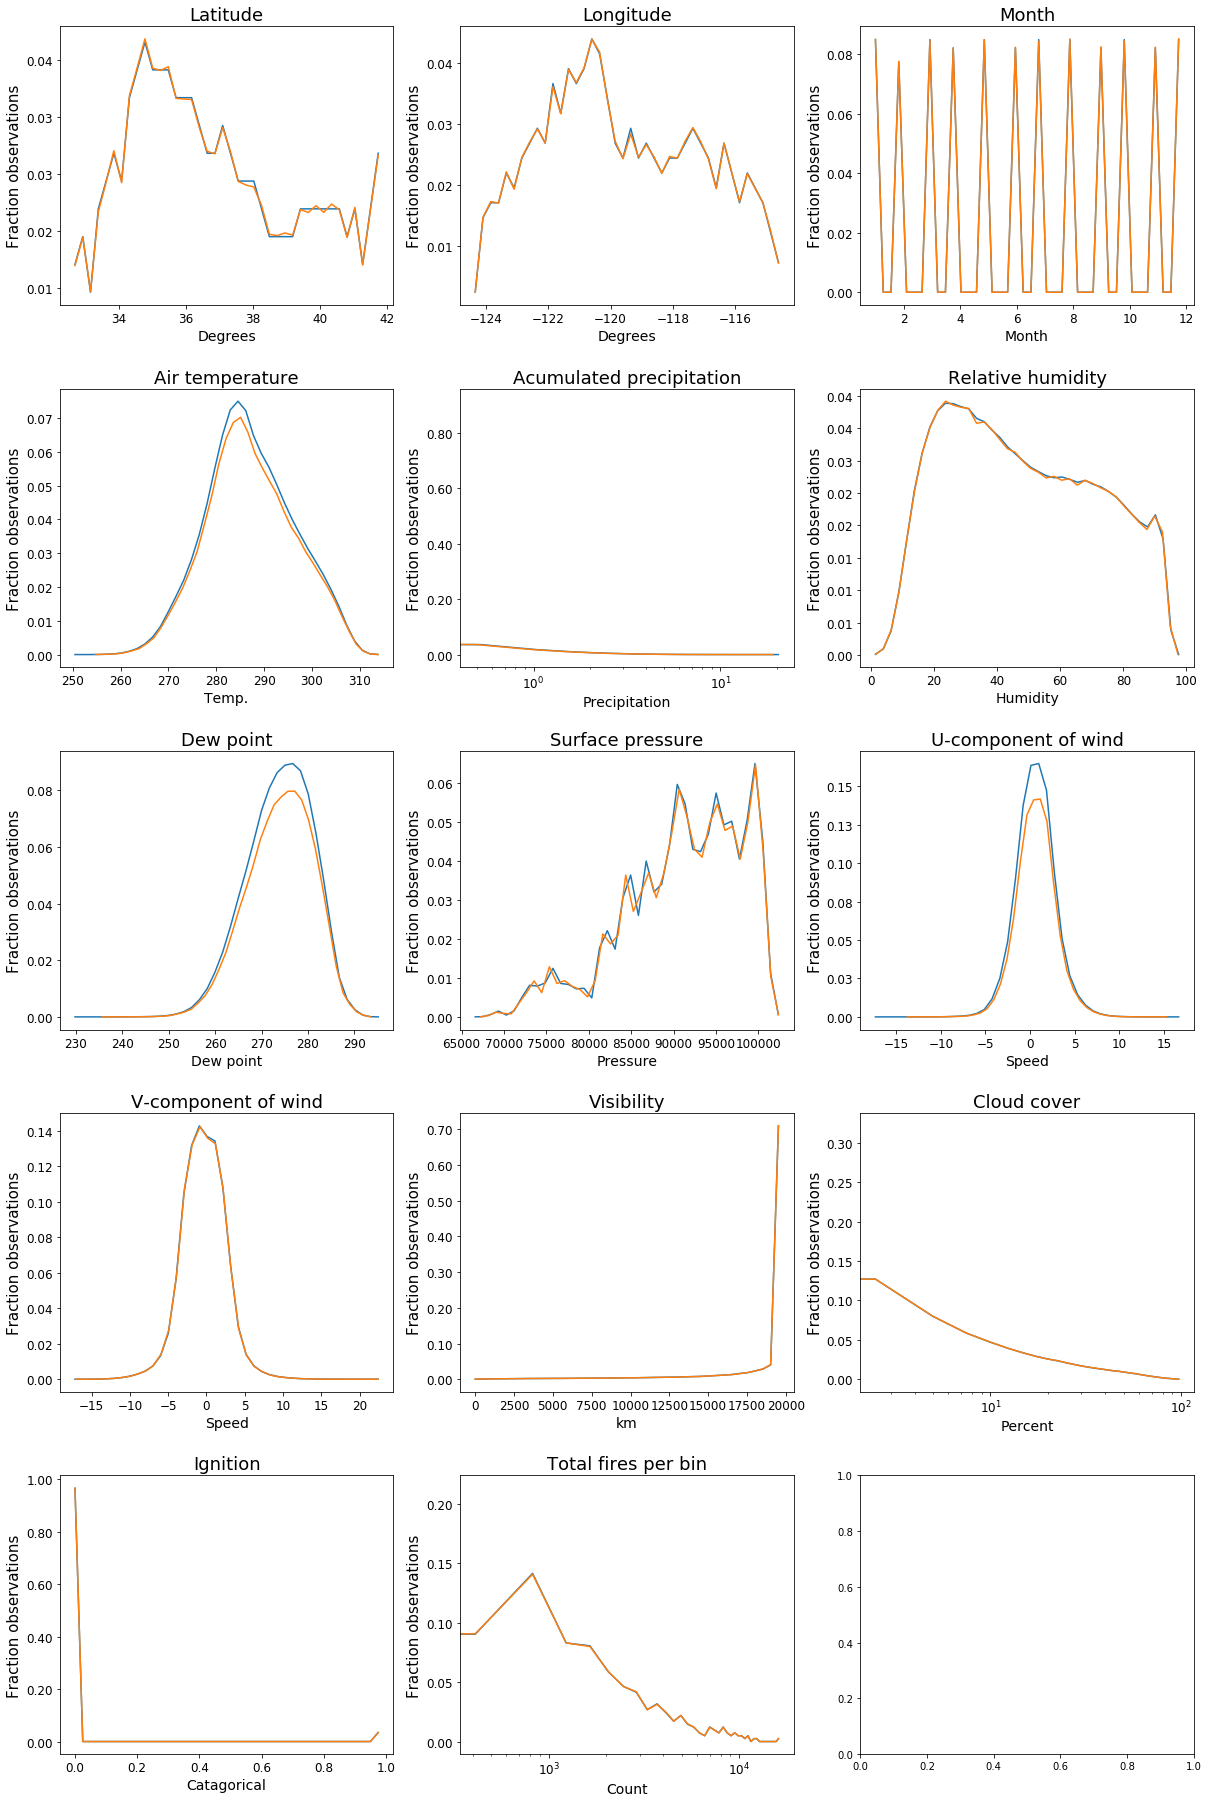

In [13]:
# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], master_df, samples[2], data_types[i], plot_titles[i], xlabels[i], ylabels[i], x_scales[i])
    
plt.show()

In [14]:
master_df.describe()

,lat,lon,month,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,mean_vwnd_10m,...,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,ignition,total_fires,crain,veg
count,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,...,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06
mean,3.712057e+01,-1.195196e+02,6.522930e+00,2.879437e+02,1.747614e-01,4.925318e+01,2.747232e+02,9.152797e+04,1.055435e+00,1.629883e-01,...,2.721587e+02,9.131632e+04,-8.593879e-01,-1.765547e+00,1.639609e+04,4.897733e+00,3.455034e-02,2.422946e+03,1.124021e-02,3.061376e+01
std,2.555418e+00,2.505702e+00,3.448704e+00,9.140187e+00,6.408220e-01,2.339893e+01,6.993439e+00,6.966659e+03,2.170170e+00,2.827547e+00,...,7.758191e+00,6.958738e+03,2.185918e+00,2.797548e+00,6.206621e+03,1.066298e+01,1.826380e-01,2.657147e+03,1.054224e-01,2.273827e+01
min,3.268389e+01,-1.243408e+02,1.000000e+00,2.504765e+02,0.000000e+00,1.478230e+00,2.298151e+02,6.661041e+04,-1.733236e+01,-1.718333e+01,...,1.960424e+02,6.626062e+04,-2.020520e+01,-2.020016e+01,4.175250e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.499029e+01,-1.214709e+02,4.000000e+00,2.816839e+02,9.497930e-05,2.927946e+01,2.700092e+02,8.715124e+04,-3.261476e-01,-1.679754e+00,...,2.671966e+02,8.694756e+04,-2.223261e+00,-3.386437e+00,1.510810e+04,0.000000e+00,0.000000e+00,5.920000e+02,0.000000e+00,8.200000e+00
50%,3.681598e+01,-1.198972e+02,7.000000e+00,2.873206e+02,7.324219e-04,4.673757e+01,2.752203e+02,9.231579e+04,1.041583e+00,1.428150e-01,...,2.727520e+02,9.209285e+04,-8.716869e-01,-1.764183e+00,2.000572e+04,5.000000e-01,0.000000e+00,1.500000e+03,0.000000e+00,3.050000e+01
75%,3.925970e+01,-1.174117e+02,1.000000e+01,2.942778e+02,2.111294e-02,6.864366e+01,2.799445e+02,9.708966e+04,2.392024e+00,2.011975e+00,...,2.777764e+02,9.687836e+04,5.657959e-01,1.006584e-01,2.000750e+04,3.333333e+00,0.000000e+00,3.288000e+03,0.000000e+00,4.360000e+01
max,4.197182e+01,-1.143645e+02,1.200000e+01,3.153345e+02,2.093382e+01,9.999260e+01,2.967875e+02,1.032571e+05,1.752185e+01,2.345413e+01,...,2.948790e+02,1.030889e+05,1.369092e+01,1.916956e+01,2.001848e+04,9.900000e+01,1.000000e+00,1.647200e+04,1.000000e+00,8.370000e+01
